**Dimensional_Reduction**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [3]:
df = pd.read_csv('./Data/car_price_preprocessed.csv')
print(df.columns.tolist())


['car_ID', 'symboling', 'CarName', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'CarBrand_alfa-romero', 'CarBrand_audi', 'CarBrand_bmw', 'CarBrand_buick', 'CarBrand_chevrolet', 'CarBrand_dodge', 'CarBrand_honda', 'CarBrand_isuzu', 'CarBrand_jaguar', 'CarBrand_mazda', 'CarBrand_mercury', 'CarBrand_mitsubishi', 'CarBrand_nissan', 'CarBrand_peugeot', 'CarBrand_plymouth', 'CarBrand_porsche', 'CarBrand_renault', 'CarBrand_saab', 'CarBrand_subaru', 'CarBrand_toyota', 'CarBrand_volkswagen', 'CarBrand_volvo', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo', 'doornumber_four', 'doornumber_two', 'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front', 'enginelocation_rear', 'enginetype_dohc', 'enginetype_dohcv', 'enginetyp

**PCA**

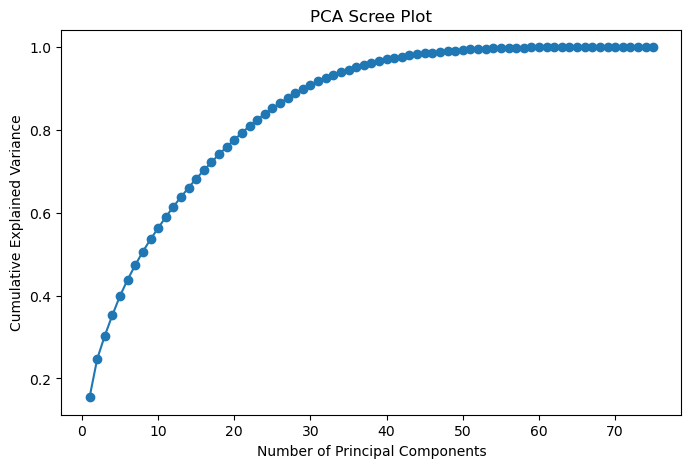

In [4]:
features = [col for col in df.columns if col not in ["car_ID", "CarName"]]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 完整 PCA，用于碎石图
pca_full = PCA()
pca_full.fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.show()

In [5]:
pca = PCA(n_components=16, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of principal components retained: {X_pca.shape[1]}")

pc_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca.to_csv("PCA/car_price_pca.csv", index=False)
print("Saved PCA results to PCA/car_price_pca.csv")

Number of principal components retained: 16
Saved PCA results to PCA/car_price_pca.csv


**AE**

Epoch [10/1500], Loss: 0.7612
Epoch [20/1500], Loss: 0.6655
Epoch [30/1500], Loss: 0.5020
Epoch [40/1500], Loss: 0.4650
Epoch [50/1500], Loss: 0.3030
Epoch [60/1500], Loss: 0.2579
Epoch [70/1500], Loss: 0.1989
Epoch [80/1500], Loss: 0.1842
Epoch [90/1500], Loss: 0.1549
Epoch [100/1500], Loss: 0.1287
Epoch [110/1500], Loss: 0.1165
Epoch [120/1500], Loss: 0.0876
Epoch [130/1500], Loss: 0.0794
Epoch [140/1500], Loss: 0.0802
Epoch [150/1500], Loss: 0.0741
Epoch [160/1500], Loss: 0.0735
Epoch [170/1500], Loss: 0.0613
Epoch [180/1500], Loss: 0.0520
Epoch [190/1500], Loss: 0.0493
Epoch [200/1500], Loss: 0.0476
Epoch [210/1500], Loss: 0.0458
Epoch [220/1500], Loss: 0.0485
Epoch [230/1500], Loss: 0.0384
Epoch [240/1500], Loss: 0.0363
Epoch [250/1500], Loss: 0.0380
Epoch [260/1500], Loss: 0.0421
Epoch [270/1500], Loss: 0.0340
Epoch [280/1500], Loss: 0.0405
Epoch [290/1500], Loss: 0.0316
Epoch [300/1500], Loss: 0.0363
Epoch [310/1500], Loss: 0.0306
Epoch [320/1500], Loss: 0.0276
Epoch [330/1500],

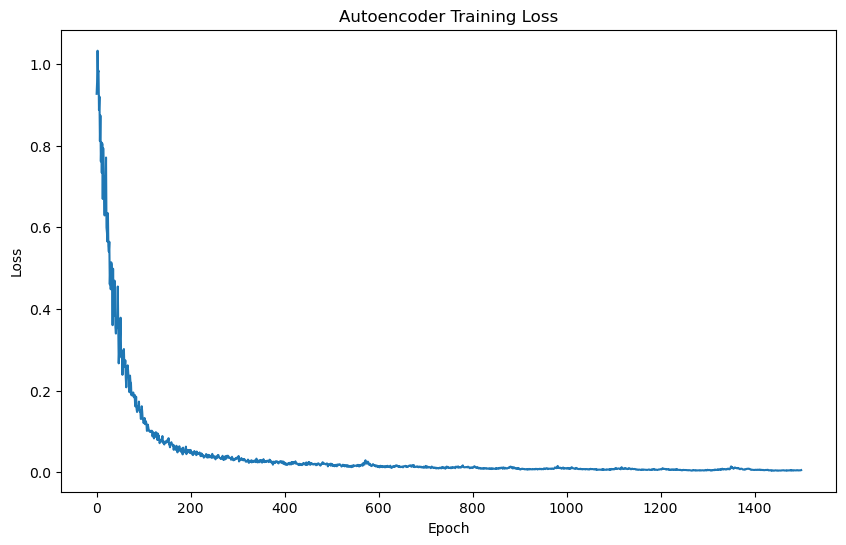

In [33]:
X_tensor = torch.FloatTensor(X_scaled)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),


            nn.Linear(128, input_dim)
            # 没有激活函数，默认回归输出（适配 MSE）
        )

    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model, loss function, optimizer, and learning rate scheduler
model = Autoencoder(X_scaled.shape[1], 32)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1500
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        # Forward pass
        encoded, decoded = model(data)
        loss = criterion(decoded, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations
model.eval()
with torch.no_grad():
    encoded_data, _ = model(X_tensor)
    encoded_data = encoded_data.numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'AE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('AE/car_price_ae.csv', index=False)

**SAE**

Pretraining individual autoencoders...

Pretraining autoencoder 1
Epoch [20/1000], Loss: 0.5918
Epoch [40/1000], Loss: 0.3830
Epoch [60/1000], Loss: 0.2053
Epoch [80/1000], Loss: 0.1705
Epoch [100/1000], Loss: 0.0977
Epoch [120/1000], Loss: 0.0737
Epoch [140/1000], Loss: 0.0561
Epoch [160/1000], Loss: 0.0514
Epoch [180/1000], Loss: 0.0419
Epoch [200/1000], Loss: 0.0398
Epoch [220/1000], Loss: 0.0373
Epoch [240/1000], Loss: 0.0297
Epoch [260/1000], Loss: 0.0256
Epoch [280/1000], Loss: 0.0297
Epoch [300/1000], Loss: 0.0268
Epoch [320/1000], Loss: 0.0197
Epoch [340/1000], Loss: 0.0216
Epoch [360/1000], Loss: 0.0194
Epoch [380/1000], Loss: 0.0197
Epoch [400/1000], Loss: 0.0171
Epoch [420/1000], Loss: 0.0170
Epoch [440/1000], Loss: 0.0368
Epoch [460/1000], Loss: 0.0175
Epoch [480/1000], Loss: 0.0141
Epoch [500/1000], Loss: 0.0121
Epoch [520/1000], Loss: 0.0121
Epoch [540/1000], Loss: 0.0117
Epoch [560/1000], Loss: 0.0110
Epoch [580/1000], Loss: 0.0096
Epoch [600/1000], Loss: 0.0097
Epoch [6

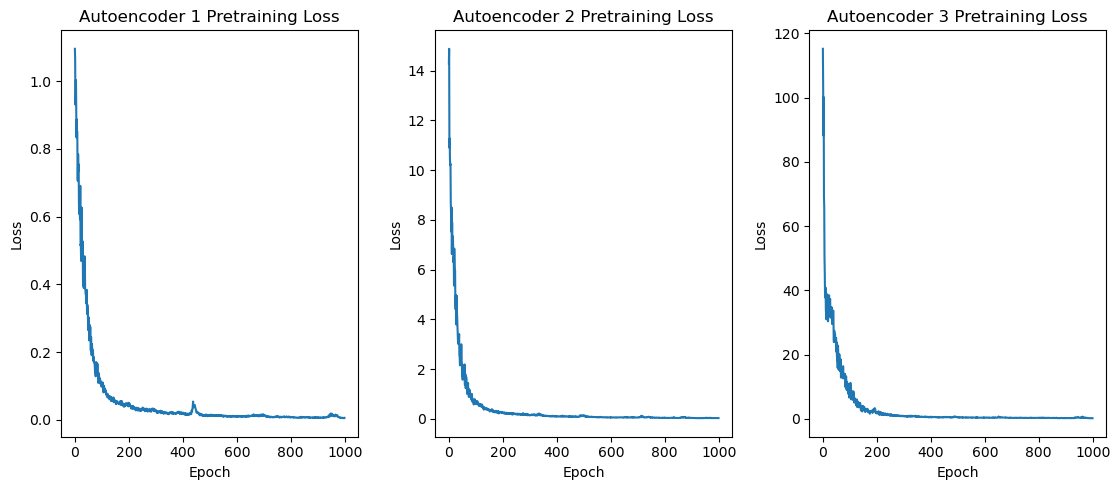


Fine-tuning complete model...
Epoch [10/1000], Loss: 0.0199
Epoch [20/1000], Loss: 0.0170
Epoch [30/1000], Loss: 0.0163
Epoch [40/1000], Loss: 0.0129
Epoch [50/1000], Loss: 0.0122
Epoch [60/1000], Loss: 0.0093
Epoch [70/1000], Loss: 0.0114
Epoch [80/1000], Loss: 0.0112
Epoch [90/1000], Loss: 0.0109
Epoch [100/1000], Loss: 0.0092
Epoch [110/1000], Loss: 0.0098
Epoch [120/1000], Loss: 0.0087
Epoch [130/1000], Loss: 0.0100
Epoch [140/1000], Loss: 0.0085
Epoch [150/1000], Loss: 0.0096
Epoch [160/1000], Loss: 0.0090
Epoch [170/1000], Loss: 0.0080
Epoch [180/1000], Loss: 0.0085
Epoch [190/1000], Loss: 0.0081
Epoch [200/1000], Loss: 0.0088
Epoch [210/1000], Loss: 0.0073
Epoch [220/1000], Loss: 0.0088
Epoch [230/1000], Loss: 0.0081
Epoch [240/1000], Loss: 0.0086
Epoch [250/1000], Loss: 0.0081
Epoch [260/1000], Loss: 0.0072
Epoch [270/1000], Loss: 0.0066
Epoch [280/1000], Loss: 0.0072
Epoch [290/1000], Loss: 0.0063
Epoch [300/1000], Loss: 0.0071
Epoch [310/1000], Loss: 0.0077
Epoch [320/1000],

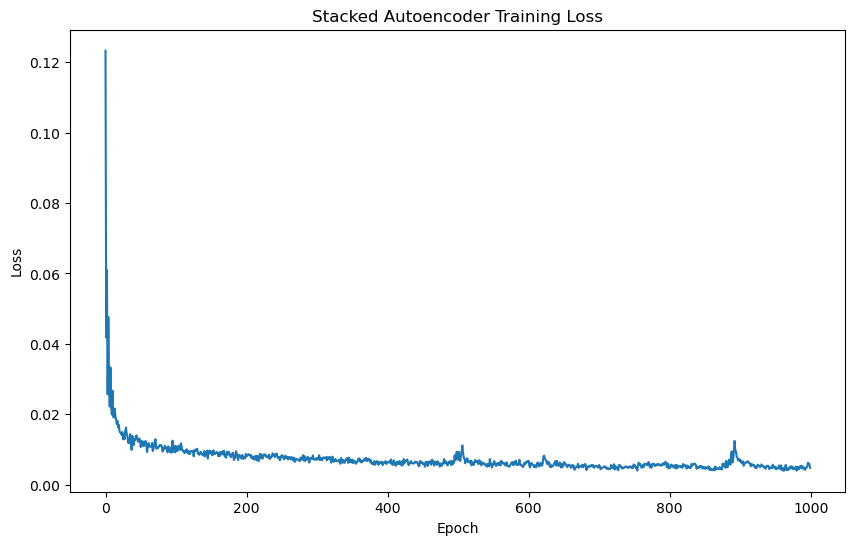

In [61]:
class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dims):
        super(StackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Create stack of autoencoders
        curr_dim = input_dim
        for encoding_dim in encoding_dims:
            self.autoencoders.append(Autoencoder(curr_dim, encoding_dim))
            curr_dim = encoding_dim
            
    def forward(self, x):
        encoded = x
        encoded_features = []
        for autoencoder in self.autoencoders:
            encoded = autoencoder.encoder(encoded)
            encoded_features.append(encoded)
            
        # Decode in reverse order
        decoded = encoded
        for autoencoder in reversed(self.autoencoders):
            decoded = autoencoder.decoder(decoded)
            
        return decoded, encoded_features

encoding_dims = [256,128,32]  # Progressive reduction in dimensions

model = StackedAutoencoder(X_scaled.shape[1], encoding_dims)
criterion = nn.MSELoss()

# Pretrain each autoencoder layer
print("Pretraining individual autoencoders...")
curr_input = X_tensor
pretrain_losses = []  # To store losses for each autoencoder
for i, autoencoder in enumerate(model.autoencoders):
    print(f"\nPretraining autoencoder {i+1}")
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    
    pretrain_epochs = 1000
    losses = []  # Store losses for the current autoencoder
    for epoch in range(pretrain_epochs):
        for data, _ in dataloader:
            if i > 0:
                with torch.no_grad():
                    for j in range(i):
                        data = model.autoencoders[j].encoder(data)
            
            encoded = autoencoder.encoder(data)
            decoded = autoencoder.decoder(encoded)
            loss = criterion(decoded, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{pretrain_epochs}], Loss: {loss.item():.4f}')
    
    pretrain_losses.append(losses)  # Store losses for plotting

# Plot pretraining losses for each autoencoder
plt.figure(figsize=(15, 5))
for i, losses in enumerate(pretrain_losses):
    plt.subplot(1, 4, i + 1)
    plt.plot(losses)
    plt.title(f'Autoencoder {i + 1} Pretraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# Fine-tune the entire model
print("\nFine-tuning complete model...")
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        decoded, encoded_features = model(data)
        loss = criterion(decoded, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Stacked Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations (using the final encoding layer)
model.eval()
with torch.no_grad():
    _, encoded_features = model(X_tensor)
    # Get the final encoded representation (32 dimensions)
    encoded_data = encoded_features[-1].numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'SAE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('SAE/car_price_sae.csv', index=False)